# Семантическая сегментация изображений

В этом ipython notebook будет рассмотрен алгоритм решения задачи семантической сегментации изображения с помощью полносверточной нейронной сети и Марковского Случайного Поля. 

Для корректной работы требуются следующие библиотеки:
* Python (>=3.5)
* cython (>=0.22), numpy, scikit-image, tensorflow (>=1.8.0), tqdm, matplotlib, pandas
* PyDenseCRF (установка последней версии: ```pip install git+https://github.com/lucasb-eyer/pydensecrf.git```)

In [0]:
import math
import os
#os.chdir("drive/My Drive/notebook/")
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.io as io
import tensorflow as tf

from tqdm import tqdm

from model_fcn8s import FCN8s
from utils import construct_dataset, reshape_and_filter_batch

%matplotlib inline
warnings.filterwarnings('ignore', category=UserWarning)

In [0]:
# network params
TEST_BATCH = 2

# pre-defined values for PASCALVOC
N_CLASSES = 21
IGN_LABEL = 255  # IGN_LABEL defines ambigious regions on images, all these regions are not considered during training / evaluation
TST_SIZE = 1449

# inference options
# Requires large amount of RAM (~20GB in total), if turned off - dumps everything on disk
RESULTS_BUFFER = False
# If you have GPU, FCN8-s model is used instead of FCN32-s
WITH_GPU = True

## Датасет и модель

В качестве модели будет использовать полносверточная сеть FCN-8s (или FCN-32s в случае запуска на CPU), предложенная в статье [Fully Convolutional Networks for Semantic Segmentation](https://arxiv.org/pdf/1605.06211.pdf). Авторы предлагают способ преобразования архитектуры VGG-16 в полносверточную нейронную сеть путем замены последних полносвязных слоев на сверточные, соответствующего размера. Еще одно новшество данной архитектуры - комбинирование предсказаний по выходам различных по глубине слоев сети для повышения качества сегментации. Например, для архитектуры FCN-32s в конце работы происходит upsampling результирующей семантической карты в 32 раза, что в итоге дает достаточно грубые предсказания границ. Для архитектуры FCN-8s повышение разрешения происходит поэтапно (2x->2x->8x), при этом после первых двух увеличений размерности к результату прибавляются предсказания на основе выходов других слоев (pool4 и pool3 соответственно), что позволяет значительно повысить точность результирующей семантической карты. Архитектура FCN-8s: <img src="ipynb_pictures/fcn.png">

Для экспериментов будет использоваться датасет [PASCAL VOC](http://host.robots.ox.ac.uk/pascal/VOC/), изображения в котором содержат объекты 21 класса (включая фон).

Ниже представлен код для загрузки изображений с помощью предварительно полученных [tfrecord](https://www.tensorflow.org/guide/datasets), а так же весов предобученной модели. Для передачи изображений в модель будет использоваться TFRecordDataset с one_shot_iterator, подробнее почитать о датасетах и итераторах в TF можно, например, [здесь](https://towardsdatascience.com/how-to-use-dataset-in-tensorflow-c758ef9e4428).

Перед запуском следующей клетки обратите внимание на флаги в предыдущей - RESULTS_BUFFER и WITH_GPU, выставьте их в зависимости от имеющихся в вашем распоряжении ресурсов.

In [0]:
#!pip install cython
# load tfrecords to dataset object
test_dataset = construct_dataset('./tfrecord/', 'val')
# enable batching
test_dataset = test_dataset.batch(TEST_BATCH)
# create one-shot iterator
iterator = test_dataset.make_one_shot_iterator()
next_batch_op = iterator.get_next()
# load pretrained weights (if you have GPU consider using 'reduced=False')
model_eval = FCN8s("./weights/fcn{}s.npy".format(8 if WITH_GPU else 32), reduced=not(WITH_GPU))
# placeholder to turn dropout off at test time
dropout_prob = tf.placeholder_with_default(1.0, shape=())
# forward pass of the model (logits for loss, soft_logits for dense-CRF)
logits, soft_logits = model_eval.build(next_batch_op['img'], dropout_prob)
# filtering the IGN_LABEL from masks and logits for correct loss computation
filter_logits, filter_labels = reshape_and_filter_batch(logits, next_batch_op['mask'])
# applying loss
loss = tf.nn.softmax_cross_entropy_with_logits_v2(
    logits=filter_logits, labels=filter_labels)
mean_loss = tf.reduce_mean(loss)
# global initialization
init = tf.global_variables_initializer()

    100% |████████████████████████████████| 2.1MB 6.6MB/s 


## Предсказание семантической карты с помощью предобученной модели

Код в клетке ниже получает предсказания для всех 1449 изображений из validation части PASCAL VOC. Изображения и эталонные маски так же сохраняются для того, чтобы в конце можно было наглядно оценить результаты.

In [0]:
if RESULTS_BUFFER:
    predictions = []
    groundtruth = []
    images = []
else:
    os.makedirs('./data/images', exist_ok=True)
    os.makedirs('./data/masks', exist_ok=True)
    os.makedirs('./data/predictions', exist_ok=True)
    
filenames = []
evaluation_loss = 0
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    for batch_i in tqdm(range(0, math.ceil(TST_SIZE / TEST_BATCH))):
        preds, gts, imgs, fnames, m_loss = sess.run(
            [
                soft_logits, next_batch_op['mask'], next_batch_op['img'], 
                next_batch_op['filename'], mean_loss
            ],
            feed_dict={dropout_prob: 1.0})
        
        fnames = [fname.decode() for fname in fnames]
        filenames.extend(fnames)
        if RESULTS_BUFFER:
            predictions.extend(preds)
            groundtruth.extend(gts)
            images.extend(imgs)
        else:
            for i in range(0, len(preds)):
                io.imsave('./data/images/{}.jpg'.format(fnames[i]), imgs[i])
                io.imsave('./data/masks/{}.png'.format(fnames[i]), gts[i])
                np.save('./data/predictions/{}.npy'.format(fnames[i]), preds[i])
        evaluation_loss += m_loss
print('Evaluation loss is: {:.6f}'.format( evaluation_loss / TST_SIZE))

## Оценка точности предсказаний
Используемые метрики:
1. пиксельная точность (pixel accuracy): $\sum_{c=1}^{N_c}{n_{cc}}~/~\sum_{c=1}^{N_c}{n_c}$;
2. средняя точность (mean accuracy): $\frac{1}{N_c}\sum_{c=1}^{N_c}{(n_{cc}~/~n_c)}$;
3. средний коэффициент Жаккара (mean intersection over union): 
$\frac{1}{N_c}\sum_{c=1}^{N_c}{[n_{cc}~/~(n_c+\sum_{c'}^{N_c}{n_{c'c}}-n_{cc})]}$;

где: 
* $N_c$ - число классов в эталонной разметке для рассматриваемого изображения;
* $n_{ij}$ - число пикселей класса $i$, с предсказанным классом $j$ на рассматриваемом изображении;
* $n_c=\sum_{j}^{N_c}{n_{cj}}$ - общее число пикселей с эталонным классом $c$ на рассматриваемом изображении.

Реализуйте три метрики по описанным выше формулам.

In [0]:
def pixel_accuracy(pred, mask):
    if pred.ndim == 3:
        pred = np.argmax(pred, axis=-1)
    return ((pred==mask).sum())/((mask !=255).sum())
    # =====================================================
    # ================== YOUR CODE HERE ===================
    # =====================================================

def mean_accuracy(pred, mask):
    if pred.ndim == 3:
        pred = np.argmax(pred, axis=-1)
    output = 0.0
    Nc = np.max(pred)+1
    n_arr = mask.copy()
    for i in range(pred.shape[0]):
      for j in range(pred.shape[1]):
          if n_arr[i,j] != pred[i,j] :
            n_arr[i,j] = 255
    for i in range(Nc):
        len1 = (n_arr == i).sum()
        output += (1/Nc)*len1/((mask == i).sum() + 1e-5 )
    return output
    # =====================================================
    # ================== YOUR CODE HERE ===================
    # =====================================================

def mean_iu(pred, mask):
    if pred.ndim == 3:
        pred = np.argmax(pred, axis=-1)
    output = 0.0
    n_arr = mask.copy()
    Nc = np.max(pred)+1
    for i in range(pred.shape[0]):
      for j in range(pred.shape[1]):
          if n_arr[i,j] != pred[i,j] :
            n_arr[i,j] = 255
    for i in range(Nc):
        len1 = (n_arr == i).sum()
        summ_nc = (pred==i).sum()
        output += (1/Nc)*len1/((mask==i).sum() +summ_nc - len1 + 1e-5)
    return output
    
    # =====================================================
    # ================== YOUR CODE HERE ===================
    # =====================================================

## Пост обработка предсказаний с помощью Dense-CRF

Для улучшения качества предсказаний модели будем изпользовать Полносвязное Марковское Случайное Поле ([оригинальная статья](http://www.philkr.net/papers/2011-12-01-nips/2011-12-01-nips.pdf) и [python интерфейс](https://github.com/lucasb-eyer/pydensecrf)).

В процессе работы Dense-CRF минимизирует функцию энергии, заданную пользователем. Функционирование Dense-CRF для нашей задачи можно интерпретировать следующим образом: исходное RGB изображение используется для того чтобы точнее локализовать предсказания (например, цвет на границах объекта обычно сильно изменяется, поэтому делается предположение, что по разную сторону от таких границ лежат объекты разных классов), а на основе карты сегментации полученной из нейронной сети можно отбирать только наиболее правдоподобные предсказания (например, делается предположение, что все отсегментированные объекты имеют достаточно большой размер на изображении).

Разберитесь с python интерфейсом и используйте его для того, чтобы задать корректные унарные и парные потенциалы для нашей задачи.

In [42]:
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax,create_pairwise_bilateral,create_pairwise_gaussian
# placeholders for metrics' values before and after post-processing
metrics_before = np.zeros(3, dtype=np.float32)
metrics_after = np.zeros(3, dtype=np.float32)
filenames1 = os.listdir('./data/predictions')
filenames = []
for file in filenames1:
    filenames.append(os.path.splitext(file)[0])
if RESULTS_BUFFER:
    predictions_pp = []
else:
    os.makedirs('./data/predictions_pp', exist_ok=True)
for index, fname in tqdm(enumerate(filenames), total=len(filenames)):
    # selecting the next image to process
    if RESULTS_BUFFER:
        img, y_pred, y_true = images[index], predictions[index], groundtruth[index]
    else:
        img = io.imread('./data/images/{}.jpg'.format(fname))
        y_true = io.imread('./data/masks/{}.png'.format(fname))
        y_pred = np.load('./data/predictions/{}.npy'.format(fname))
    # creating a DenseCRF object
    d = dcrf.DenseCRF2D(img.shape[0], img.shape[1], N_CLASSES)
    # Unary potential from softmax
    softmax = y_pred.transpose((2, 0, 1)).reshape((N_CLASSES, -1)).copy(order='C')
    
    U = unary_from_softmax(softmax)
    d.setUnaryEnergy(U)
    # =======================================================================
    # =========================== YOUR CODE HERE ============================
    # ================ Setting unary potential from sofrmax =================
    # =======================================================================
    
    # =======================================================================
    # =========================== YOUR CODE HERE ============================
    # ====== Setting two pairwise potentials for structure and color ========
    # =======================================================================
    #d.addPairwiseBilateral(sxy=(80,80), srgb=(13,13,13), rgbim=img, compat=10, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
    #feats = create_pairwise_gaussian(sdims=(3, 3), shape=image.shape[:2])
    #d.addPairwiseEnergy(feats, compat=3, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
    
    feats = create_pairwise_gaussian(sdims=(10, 10), shape=img.shape[:2])
    d.addPairwiseEnergy(feats, compat=3,
                         kernel=dcrf.DIAG_KERNEL,
                         normalization=dcrf.NORMALIZE_SYMMETRIC)
    feats = create_pairwise_bilateral(sdims=(40, 40), schan=(13, 13, 13),
                                        img=img, chdim=2)
    d.addPairwiseEnergy(feats, compat=10,
                          kernel=dcrf.DIAG_KERNEL,
                          normalization=dcrf.NORMALIZE_SYMMETRIC)
    #good vers
    #feats = create_pairwise_bilateral(sdims=(50, 50), schan=(10, 10, 10),img=img, chdim=2)
    #d.addPairwiseEnergy(feats, compat=11,kernel=dcrf.DIAG_KERNEL,normalization=dcrf.NORMALIZE_SYMMETRIC)
    #d.addPairwiseGaussian(sxy=3, compat=11)
    # inference
    Q = d.inference(5)
    # results
    y_pred_pp = np.argmax(Q, axis=0).reshape((img.shape[0], img.shape[1]))
    # save results
    if RESULTS_BUFFER:
        predictions_pp.append(y_pred_pp)
    else:
        io.imsave('./data/predictions_pp/{}.png'.format(fname), y_pred_pp)
    # calculation of metrics
    metrics_before += [pixel_accuracy(y_pred, y_true), mean_accuracy(y_pred, y_true), mean_iu(y_pred, y_true)]
    metrics_after += [pixel_accuracy(y_pred_pp, y_true), mean_accuracy(y_pred_pp, y_true), mean_iu(y_pred_pp, y_true)]
# getting mean value of metrics    
metrics_before /= TST_SIZE
metrics_after /= TST_SIZE
# print metrics in table
metrics_df = pd.DataFrame([metrics_before, metrics_after],
                          index=['NN', 'NN and dense-CRF'],
                          columns=['pixel_accuracy', 'mean_accuracy', 'mean_iu'])
metrics_df.head()

100%|██████████| 1449/1449 [17:09<00:00,  1.49it/s]


,pixel_accuracy,mean_accuracy,mean_iu
NN,0.834393,0.261896,0.216319
NN and dense-CRF,0.842200,0.335694,0.287291


## Визуализация результатов

Визуализируйте полученные результаты - до и после пост обработки, чтобы оценить качество. Пример визуализации:
<img src="ipynb_pictures/vis_example.png">

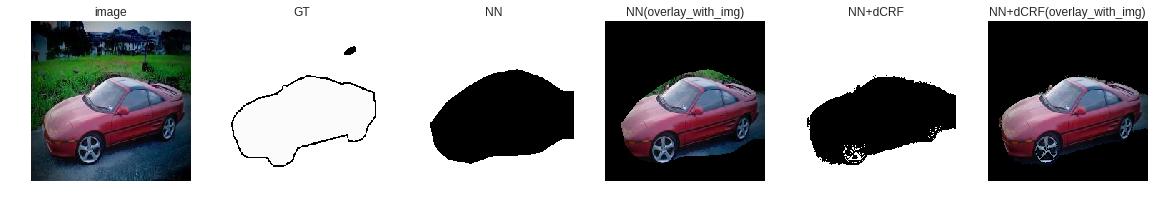

NN : pixel_accuracy:  0.9143372777424581 mean_accuracy:  0.23142832921679476 mean_iu:  0.20126490878383013
NN and dense-CRF : pixel_accuracy:  0.9648284489653617 mean_accuracy:  0.2420352043633156 mean_iu:  0.22371558967969388


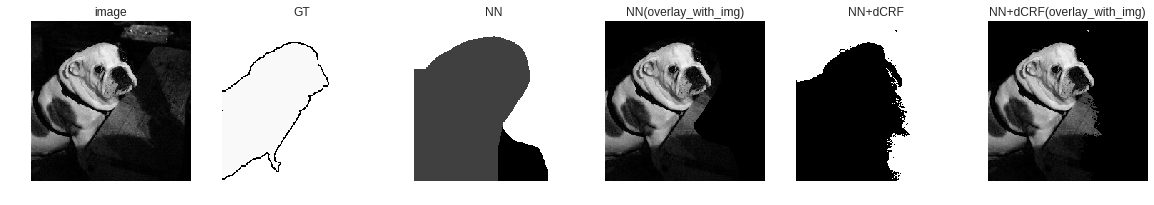

NN : pixel_accuracy:  0.7491008838768668 mean_accuracy:  0.10177480508917233 mean_iu:  0.07817245363761356
NN and dense-CRF : pixel_accuracy:  0.8441125673067155 mean_accuracy:  0.13563150138704028 mean_iu:  0.10905307189913183


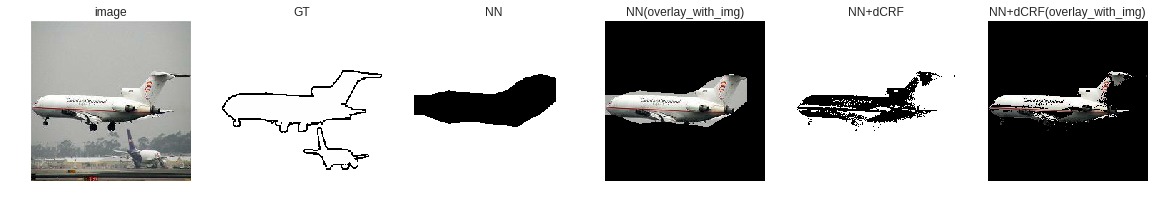

NN : pixel_accuracy:  0.9367762128325509 mean_accuracy:  0.8809352535704644 mean_iu:  0.7648666818855826
NN and dense-CRF : pixel_accuracy:  0.9327699530516432 mean_accuracy:  0.8113378968294599 mean_iu:  0.7480519662428486


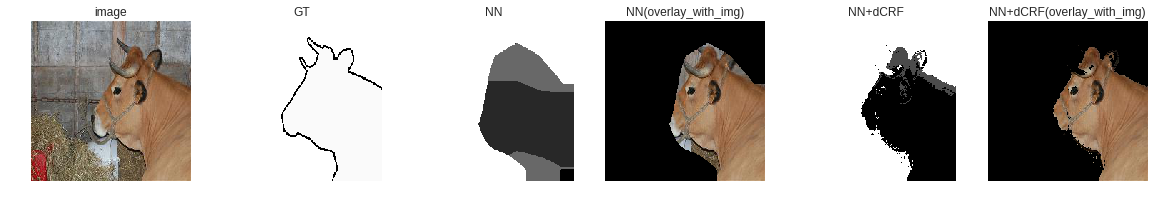

NN : pixel_accuracy:  0.7124377703419571 mean_accuracy:  0.07586735656235542 mean_iu:  0.07287849246506627
NN and dense-CRF : pixel_accuracy:  0.6900554966130743 mean_accuracy:  0.07851417279300296 mean_iu:  0.07482461240353697


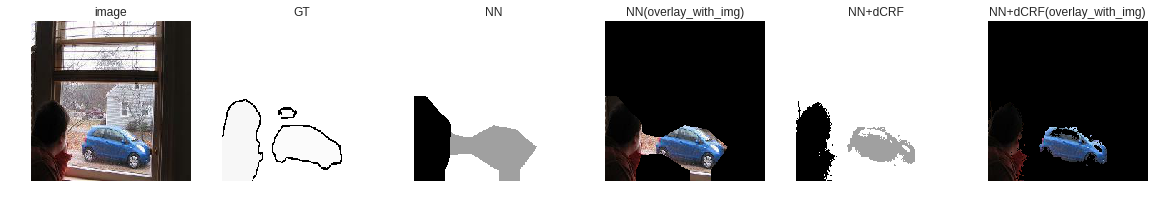

NN : pixel_accuracy:  0.9410851446314757 mean_accuracy:  0.170674500194535 mean_iu:  0.1443922508807237
NN and dense-CRF : pixel_accuracy:  0.9633314267037097 mean_accuracy:  0.16194965494003294 mean_iu:  0.15509020741850688


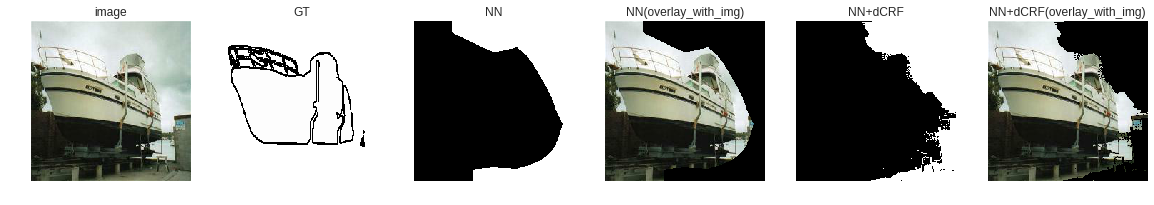

NN : pixel_accuracy:  0.6314903534895766 mean_accuracy:  0.2938785654873672 mean_iu:  0.17460178652643718
NN and dense-CRF : pixel_accuracy:  0.5780353057965385 mean_accuracy:  0.27800213568097887 mean_iu:  0.15383391134800867


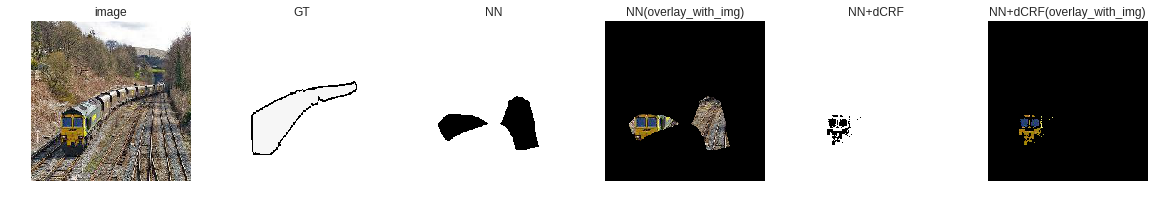

NN : pixel_accuracy:  0.8756577744367012 mean_accuracy:  0.06139729870497974 mean_iu:  0.05208350007744668
NN and dense-CRF : pixel_accuracy:  0.9125744123204453 mean_accuracy:  0.05637672341454795 mean_iu:  0.051068632109574214


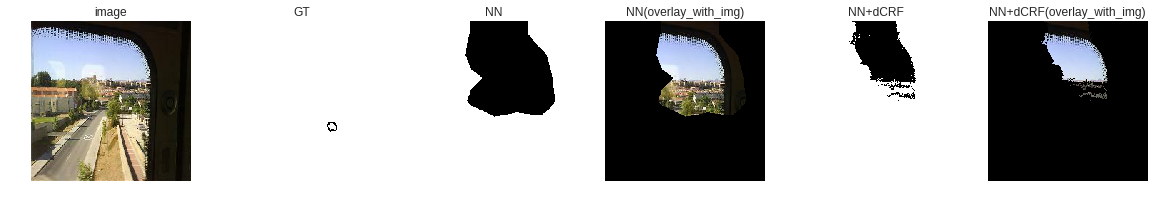

NN : pixel_accuracy:  0.7299660610900379 mean_accuracy:  0.034808237676071545 mean_iu:  0.034700710634483614
NN and dense-CRF : pixel_accuracy:  0.8830105809542823 mean_accuracy:  0.04210612494291227 mean_iu:  0.04197605380601713


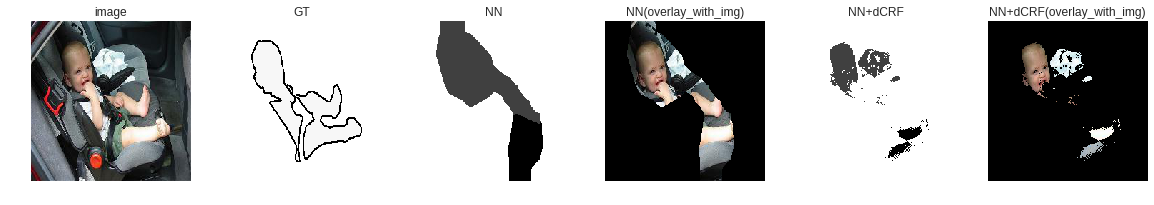

NN : pixel_accuracy:  0.723913495529216 mean_accuracy:  0.05994955991350322 mean_iu:  0.053461141133845556
NN and dense-CRF : pixel_accuracy:  0.8263048450821376 mean_accuracy:  0.06413674752676238 mean_iu:  0.055230970363664


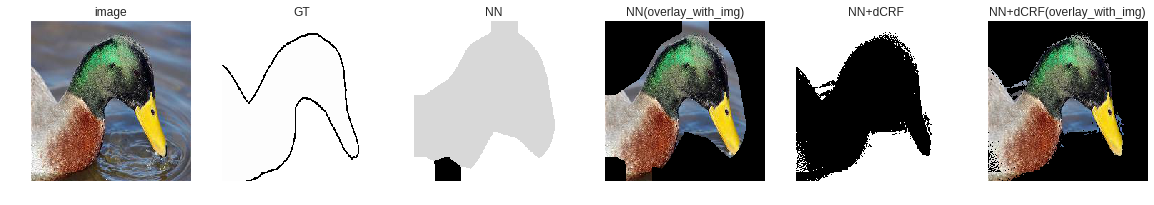

NN : pixel_accuracy:  0.823268059897976 mean_accuracy:  0.1276489181463278 mean_iu:  0.10669440980091097
NN and dense-CRF : pixel_accuracy:  0.9431462892874773 mean_accuracy:  0.4729593940080773 mean_iu:  0.43264472203495374


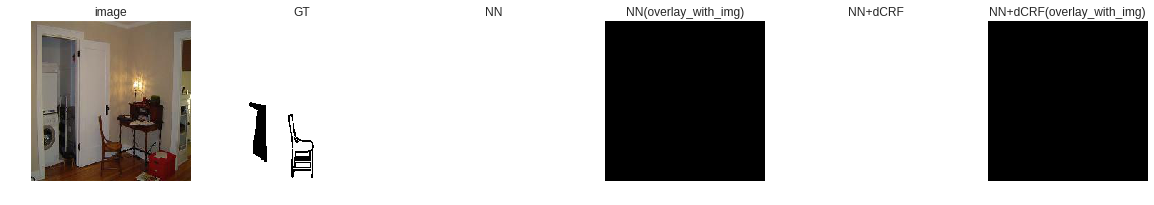

NN : pixel_accuracy:  0.9882002209852607 mean_accuracy:  0.9999999997890339 mean_iu:  0.9446946745566217
NN and dense-CRF : pixel_accuracy:  0.9882002209852607 mean_accuracy:  0.9999999997890339 mean_iu:  0.9446946745566217


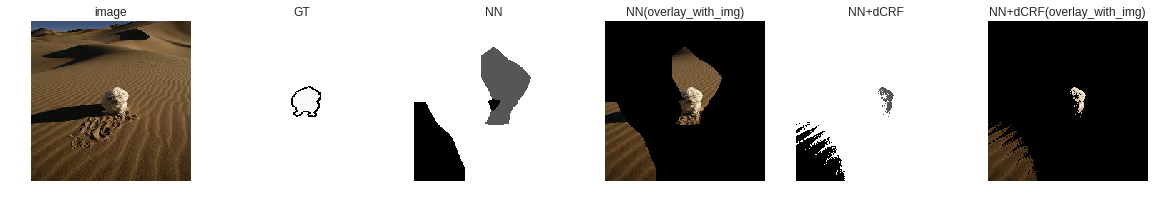

NN : pixel_accuracy:  0.7966387567014035 mean_accuracy:  0.050823683121372476 mean_iu:  0.05056252802688256
NN and dense-CRF : pixel_accuracy:  0.9073148203923458 mean_accuracy:  0.05788455624966498 mean_iu:  0.05669579225168213


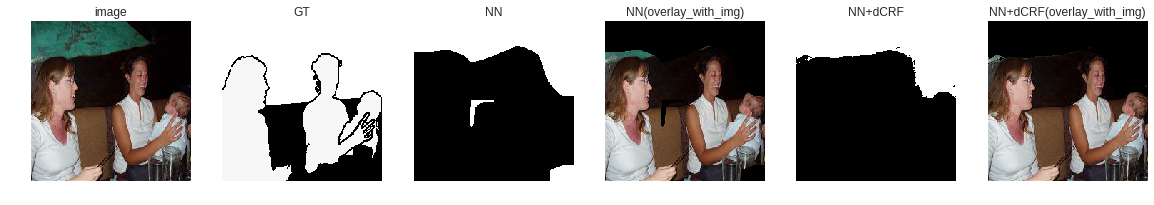

NN : pixel_accuracy:  0.8191787874887373 mean_accuracy:  0.10225955941907744 mean_iu:  0.07099875507691458
NN and dense-CRF : pixel_accuracy:  0.8569442656712576 mean_accuracy:  0.10700737001071622 mean_iu:  0.0778645255050664


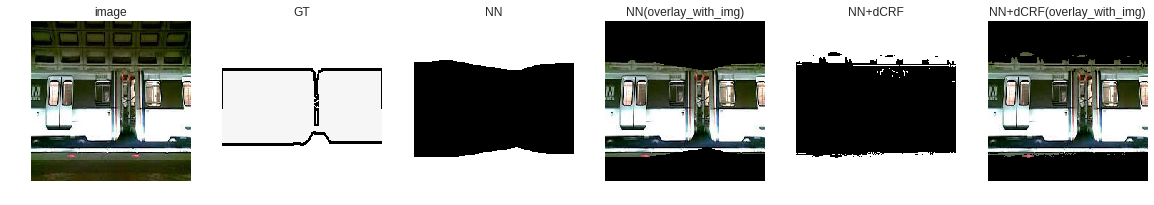

NN : pixel_accuracy:  0.9107363311083677 mean_accuracy:  0.09193847080239026 mean_iu:  0.08004508482981601
NN and dense-CRF : pixel_accuracy:  0.8957962796342408 mean_accuracy:  0.09056877534656976 mean_iu:  0.07774940842878975


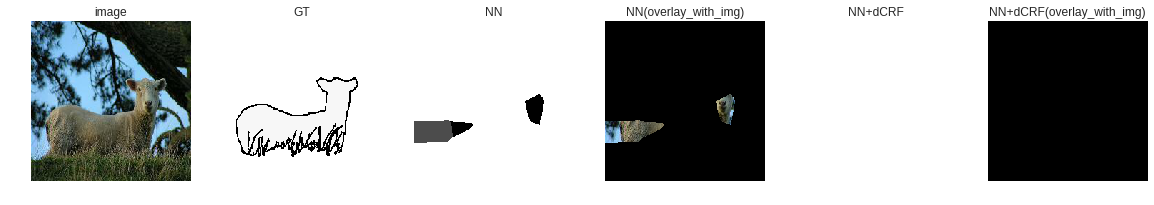

NN : pixel_accuracy:  0.8392213106110139 mean_accuracy:  0.06162974476893967 mean_iu:  0.05169082885212481
NN and dense-CRF : pixel_accuracy:  0.8330415708771856 mean_accuracy:  0.9999999997468161 mean_iu:  0.7871691643839347


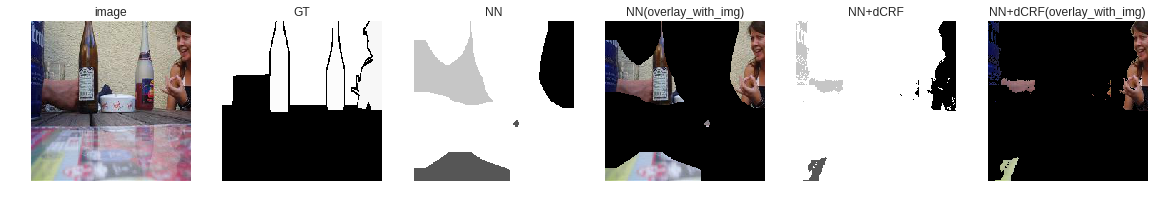

NN : pixel_accuracy:  0.6844433103682912 mean_accuracy:  0.1294452799333729 mean_iu:  0.06616429261710424
NN and dense-CRF : pixel_accuracy:  0.7445351705367015 mean_accuracy:  0.11936008324678246 mean_iu:  0.07561226503429097


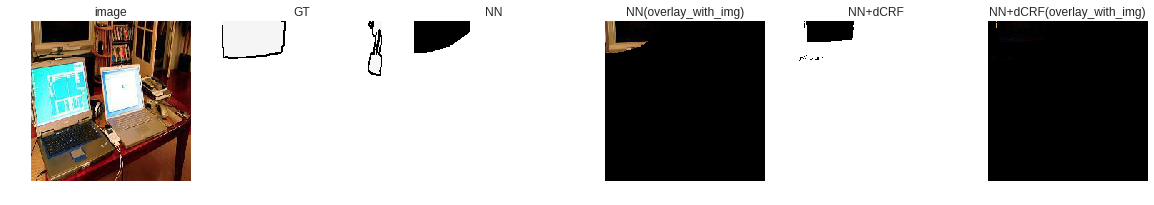

NN : pixel_accuracy:  0.9610194598323898 mean_accuracy:  0.08033703227337549 mean_iu:  0.0770141309806647
NN and dense-CRF : pixel_accuracy:  0.9426756762241026 mean_accuracy:  0.06971313529269976 mean_iu:  0.06590359919429484


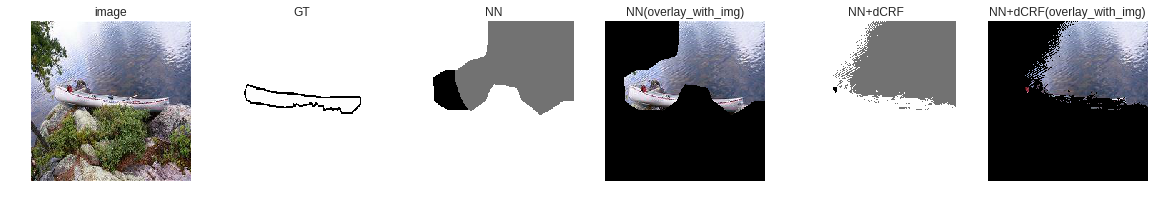

NN : pixel_accuracy:  0.6396509996135776 mean_accuracy:  0.039522726407480974 mean_iu:  0.03866129235665055
NN and dense-CRF : pixel_accuracy:  0.6542943724704591 mean_accuracy:  0.040427510452929014 mean_iu:  0.038104296156669604


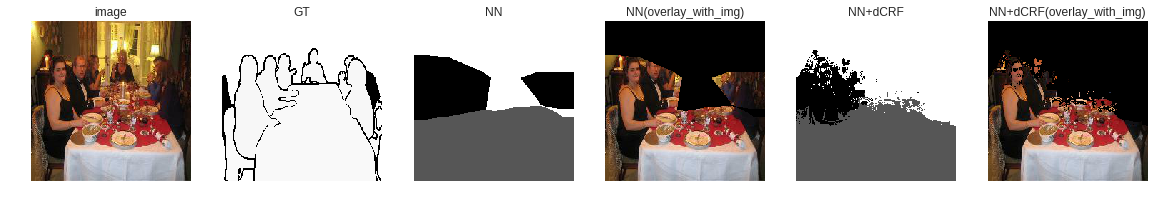

NN : pixel_accuracy:  0.7432241824533993 mean_accuracy:  0.14225098178335083 mean_iu:  0.10453503350552956
NN and dense-CRF : pixel_accuracy:  0.7336544929800577 mean_accuracy:  0.13671500780530962 mean_iu:  0.0988591527076732


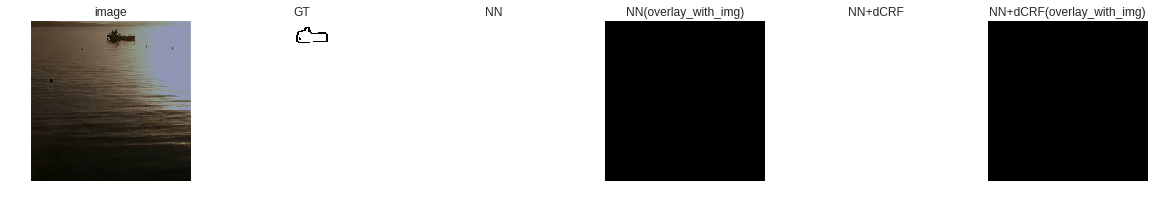

NN : pixel_accuracy:  0.9905488476402154 mean_accuracy:  0.9999999997978531 mean_iu:  0.9859095980177953
NN and dense-CRF : pixel_accuracy:  0.9905488476402154 mean_accuracy:  0.9999999997978531 mean_iu:  0.9859095980177953


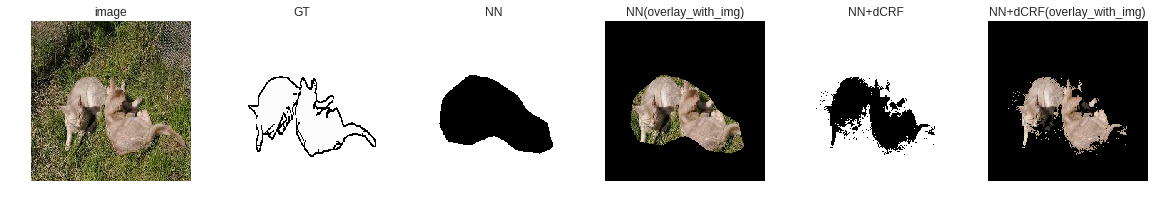

NN : pixel_accuracy:  0.7870994676964826 mean_accuracy:  0.05216080122649825 mean_iu:  0.05056796082732886
NN and dense-CRF : pixel_accuracy:  0.8361757645339735 mean_accuracy:  0.05541306992865433 mean_iu:  0.05189685148130687


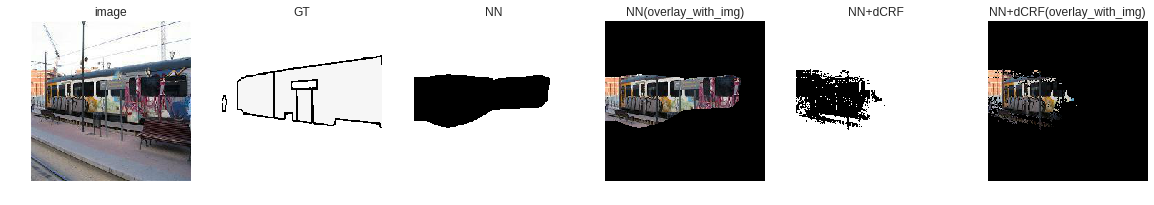

NN : pixel_accuracy:  0.8207107817771614 mean_accuracy:  0.07328595825067945 mean_iu:  0.06000511814418797
NN and dense-CRF : pixel_accuracy:  0.76130648065738 mean_accuracy:  0.0612244475402715 mean_iu:  0.04772820558894727


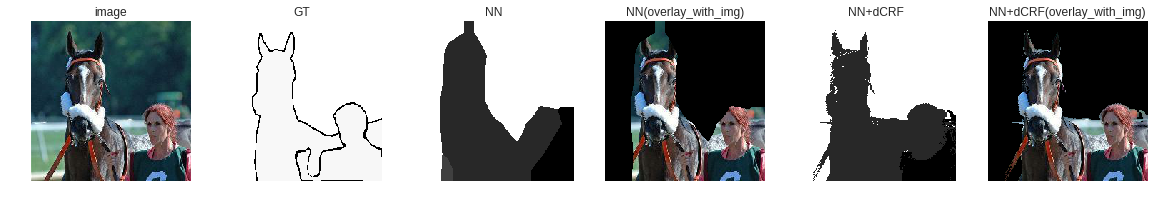

NN : pixel_accuracy:  0.8307004285803019 mean_accuracy:  0.13757253842624173 mean_iu:  0.11077299922776267
NN and dense-CRF : pixel_accuracy:  0.8825441520528375 mean_accuracy:  0.14650047857380652 mean_iu:  0.12291566455404132


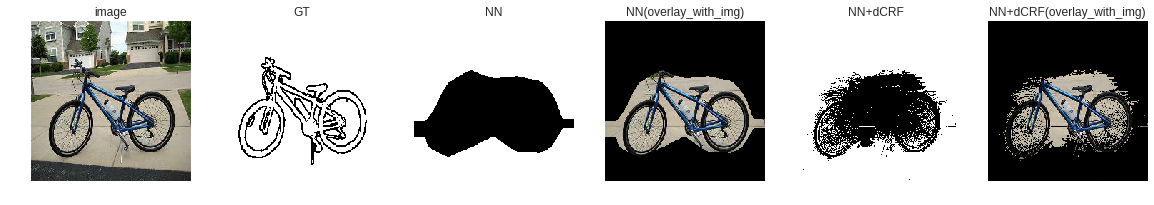

NN : pixel_accuracy:  0.8031938325991189 mean_accuracy:  0.5795434616862484 mean_iu:  0.3468700381959203
NN and dense-CRF : pixel_accuracy:  0.8409911894273128 mean_accuracy:  0.563358981769488 mean_iu:  0.3629099629592664


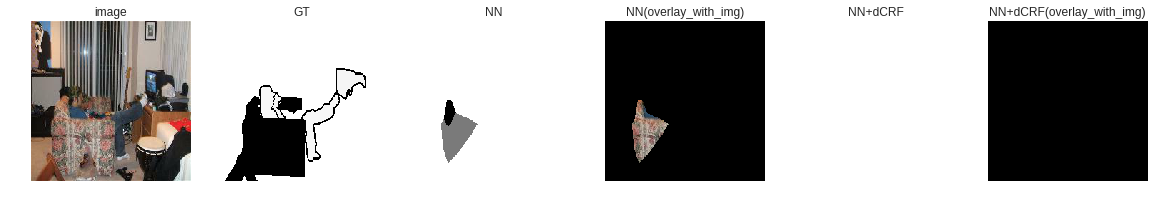

NN : pixel_accuracy:  0.9209707529558183 mean_accuracy:  0.06332681343834921 mean_iu:  0.04901463442759293
NN and dense-CRF : pixel_accuracy:  0.9204231487243311 mean_accuracy:  0.9999999997295689 mean_iu:  0.7369658799551646


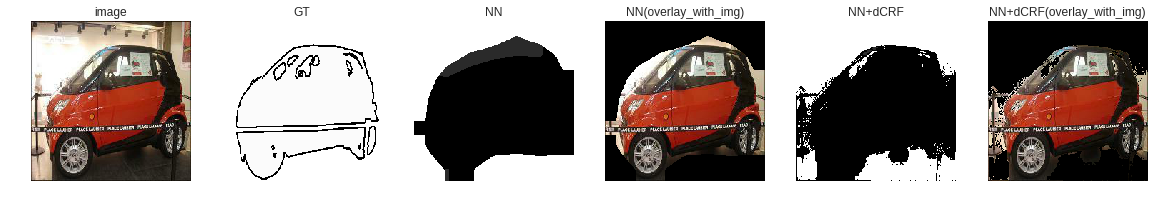

NN : pixel_accuracy:  0.8446828557968221 mean_accuracy:  0.212583044414835 mean_iu:  0.18154507397424896
NN and dense-CRF : pixel_accuracy:  0.8708724142361557 mean_accuracy:  0.21942877853946302 mean_iu:  0.18158025533834293


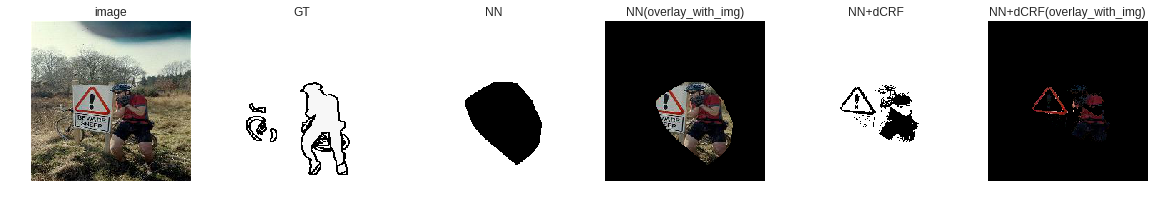

NN : pixel_accuracy:  0.9079837050102894 mean_accuracy:  0.11195355793096906 mean_iu:  0.07822351301318926
NN and dense-CRF : pixel_accuracy:  0.9431985216916551 mean_accuracy:  0.0952401165679711 mean_iu:  0.08360517143194346


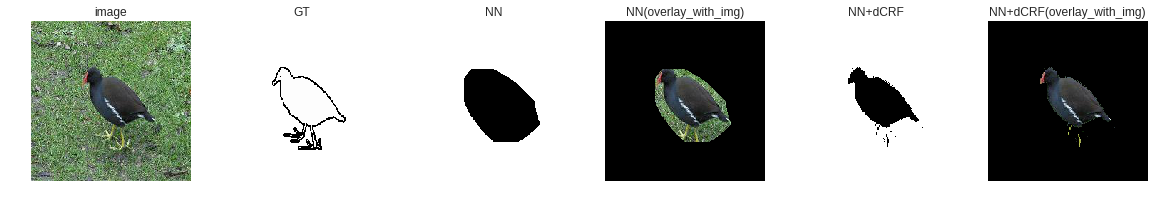

NN : pixel_accuracy:  0.9370257966616085 mean_accuracy:  0.47986914682021886 mean_iu:  0.3532568711345052
NN and dense-CRF : pixel_accuracy:  0.9972931960792355 mean_accuracy:  0.4934971690516796 mean_iu:  0.46399150993199756


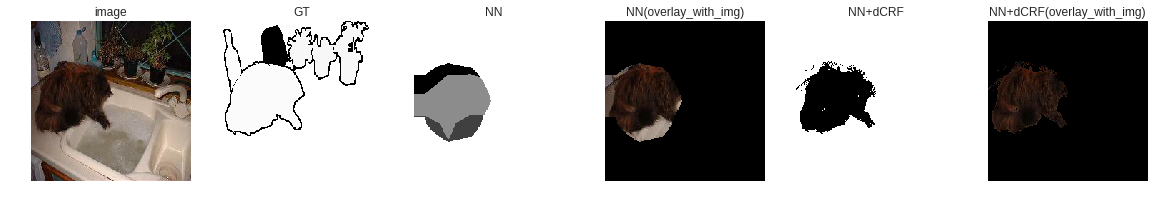

NN : pixel_accuracy:  0.799233432783815 mean_accuracy:  0.10218965666094926 mean_iu:  0.08578080856239512
NN and dense-CRF : pixel_accuracy:  0.8692480236938958 mean_accuracy:  0.21285722382728442 mean_iu:  0.18339815844316126


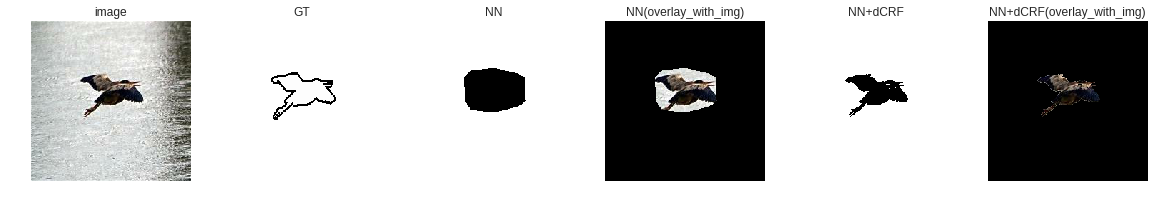

NN : pixel_accuracy:  0.9638196674661572 mean_accuracy:  0.4855658635681309 mean_iu:  0.34719252315273835
NN and dense-CRF : pixel_accuracy:  0.9994105451441115 mean_accuracy:  0.49639123814318264 mean_iu:  0.4576673085979164


In [43]:
# indexes to visualize
indexes = np.random.randint(low=0, high=TST_SIZE, size=(30))
import matplotlib.pyplot as plt
for index in indexes:
    metrics_before = [pixel_accuracy(y_pred, y_true), mean_accuracy(y_pred, y_true), mean_iu(y_pred, y_true)]
    metrics_after = [pixel_accuracy(y_pred_pp, y_true), mean_accuracy(y_pred_pp, y_true), mean_iu(y_pred_pp, y_true)]
    a = plt.figure(figsize=(20, 20))
    if RESULTS_BUFFER:
        img, y_pred, y_true, y_pred_pp = images[index], predictions[index], groundtruth[index], predictions_pp[index]
    else:
        img = io.imread('./data/images/{}.jpg'.format(filenames[index]))
        y_true = io.imread('./data/masks/{}.png'.format(filenames[index]))
        y_pred = np.load('./data/predictions/{}.npy'.format(filenames[index]))
        y_pred_pp = io.imread('./data/predictions_pp/{}.png'.format(filenames[index]))
    if y_pred.ndim == 3:
        y_pred = np.argmax(y_pred, axis=-1)
    plt.subplot(1, 6, 1 )
    plt.axis('off')
    plt.imshow(img)
    plt.title('image')
    plt.subplot(1, 6, 2 )
    plt.axis('off')
    plt.imshow(y_true)
    plt.title('GT')
    plt.subplot(1, 6, 3 )
    plt.axis('off')
    plt.imshow(y_pred)
    plt.title('NN')
    plt.subplot(1, 6, 4 )
    plt.axis('off')
    img1 = img.copy()
    img1[np.where(y_pred == 0)] = 0
    
    plt.title('NN(overlay_with_img)')
    plt.imshow(img1)
    plt.subplot(1, 6, 5 )
    plt.axis('off')
    plt.title('NN+dCRF')
    plt.imshow(y_pred_pp)
    plt.subplot(1, 6, 6 )
    plt.axis('off')
    img1 = img.copy()
    img1[np.where(y_pred_pp == 0)] = 0
    plt.title('NN+dCRF(overlay_with_img)')
    plt.imshow(img1)
    plt.show()
    # =======================================================================
    # =========================== YOUR CODE HERE ============================
    # =======================================================================
    print('NN :','pixel_accuracy: ', pixel_accuracy(y_pred, y_true),'mean_accuracy: ',  mean_accuracy(y_pred, y_true),'mean_iu: ', mean_iu(y_pred, y_true))
    print('NN and dense-CRF :','pixel_accuracy: ', pixel_accuracy(y_pred_pp, y_true),'mean_accuracy: ',  mean_accuracy(y_pred_pp, y_true),'mean_iu: ', mean_iu(y_pred_pp, y_true))

## Выводы
Сделайте выводы (в свободной форме) на основе сравнения качества по метрикам и визуально:




Визуально, результаты построенного метода NN +dCRF выглядят намного естественнее, чем результаты, полученные просто с помощью NN.
Из полученных результатов рассмотрим первые 4.

В первом изображении наибольшие отклонения по метрикам получили pixel_accuracy, mean_iu.В результате NN+dCRF четко выявляется граница автомобиля, однако только pixel_accuracy сильно вырастает в значении.

В втором изображении наибольшее отклонение по метрикам получила pixel_accuracy.В результате NN+dCRF удаляется лишний сегмент, не выделенный в GT, следовательно, поднимается точность.

В третьем изображении, при визуальном улучшении детекции, все метрики, кроме pixel_accuracy, сильно уменьшились.В данном изображении повреждаются границы шасси самолета, однако удаляются лишние сегменты неба, выявленные простым NN.

В четвертом изображении, при визуальном улучшении детекции, метрика pixel_accuracy уменьшилась, а остальные немного увеличились.Результат NN +dCRF размывает границу, по сравнению, с NN, но визуально более приятен, так как выделяет точно область объекта, хоть и не повторяет идеально границу.

Подводя итог, можно сделать вывод, что pixel_accuracy сильно реагирует на детектирование границ изображения, в то время как mean_accuracy реагирует на детектирование области в целом, а mean_iu объединяет результаты первых двух метрик, то есть при улучшении детектирования или области, или границы, она улучшается, в то время как первые две метрики реагируют лишь на один фактор.

Если опираться на метрики без визуального сопровождения, пытаясь выявить успешность улучшения детекции, то ответ неоднозначен.Не существует пока идеальных метрик, которые "хорошо" оценивают, насколько визуально человек удовлетворен результатом.

Однако, если выбирать из данных метрик, то следует отдать предпочтение pixel_accuracy, так как человек детектирует объект,в основном,реагируя на его границу, однако, если объект замаскирован или его граница смазана, то можно опираться на значение точность mean_iu.